# EfficientDet Model and GradCam Analysis

This notebook contains the training of the efficientdet model along with results and GradCam Analysis.

The EfficientDet model contains:
- EfficientNet b0 backbone
- Adam Optimiser
- Learning Rate of 0.001
- 10 epochs

# 1. Set up

In [17]:
!pip install effdet
!pip install albumentations
!pip install pytorch-lightning
!pip install fastcore
!pip install fasttransform
!pip install ensemble-boxes

## 1.1 Imports

In [2]:
# Basic
import os
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
from sklearn.model_selection import train_test_split

# effdet
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict

# Neural networks
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import timm
import torch.nn.functional as F


# DataModule
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader

# Training loop
from numbers import Number
from typing import List
from functools import singledispatch
import torch
from pytorch_lightning import LightningModule
from ensemble_boxes import ensemble_boxes_wbf
from pytorch_lightning import Trainer


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 1.2 Parameters

In [3]:
TRAIN_IMAGE_DIR = '/kaggle/input/opi-xray-dataset/OPIXray_dataset/train/train_image'
TRAIN_ANNO_DIR = '/kaggle/input/opi-xray-dataset/OPIXray_dataset/train/train_annotation'

TEST_IMAGE_DIR = '/kaggle/input/opi-xray-dataset/OPIXray_dataset/test/test_image'
TEST_ANNO_DIR = '/kaggle/input/opi-xray-dataset/OPIXray_dataset/test/test_annotation'

occlu_lvl_1 = '/kaggle/input/opi-xray-dataset/OPIXray_dataset/test/test_knife-1.txt'
occlu_lvl_2 = '/kaggle/input/opi-xray-dataset/OPIXray_dataset/test/test_knife-2.txt'
occlu_lvl_3 = '/kaggle/input/opi-xray-dataset/OPIXray_dataset/test/test_knife-3.txt'

CLASS_TO_LABEL = {
    'Folding_Knife': 0,
    'Multi-tool_Knife': 1,
    'Scissor': 2,
    'Straight_Knife': 3,
    'Utility_Knife': 4,
}

# CLASS_TO_LABEL = {
#     'Straight_Knife': 0,
#     'Folding_Knife': 1,
#     'Scissor': 2,
#     'Utility_Knife': 3,
#     'Multi-tool_Knife': 4,
# }

MODEL_ARCHITECTURE = 'tf_efficientnetv2_b0'
IMG_SIZE = 512
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

## 1.3 Preprocessing

In [4]:
# Create dataframe of annotations
def create_df(TRAIN_ANNO_DIR):
    image = []
    class_list = []
    labels = []
    xmin = []
    ymin = []
    xmax = []
    ymax =[]
    for file in os.listdir(TRAIN_ANNO_DIR):
        with open(os.path.join(TRAIN_ANNO_DIR, file), "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                image.append(parts[0])
                class_list.append(parts[1])
                labels.append(CLASS_TO_LABEL[parts[1]])
                xmin.append(float(max(0,int(parts[2]))))
                ymin.append(float(max(0,int(parts[3]))))
                xmax.append(float(parts[4]))
                ymax.append(float(parts[5]))
                # if (float(parts[2]) < 0 or float(parts[3]) < 0):
                #     print(file)
                    # print('hi')
    
    df = pd.DataFrame({
        "image": image,
        "class": class_list,
        "label": labels,
        "xmin": xmin,
        "ymin": ymin,
        "xmax": xmax,
        "ymax": ymax,
    })
    return df
                
df = create_df(TRAIN_ANNO_DIR)

In [5]:
df

,image,class,label,xmin,ymin,xmax,ymax
0,028894.jpg,Utility_Knife,4,709.0,451.0,799.0,662.0
1,040824.jpg,Folding_Knife,0,431.0,428.0,531.0,488.0
2,031619.jpg,Utility_Knife,4,431.0,507.0,553.0,593.0
3,026141.jpg,Folding_Knife,0,392.0,400.0,441.0,538.0
4,040290.jpg,Utility_Knife,4,703.0,283.0,898.0,371.0
...,...,...,...,...,...,...,...
7134,010177.jpg,Straight_Knife,3,328.0,453.0,404.0,604.0
7135,041992.jpg,Folding_Knife,0,501.0,312.0,601.0,399.0
7136,019036.jpg,Scissor,2,724.0,490.0,811.0,714.0
7137,016498.jpg,Scissor,2,752.0,477.0,840.0,592.0


In [6]:
train_df, val_df = train_test_split(
    df,
    test_size=0.1,  
    random_state=42,
    stratify=df['class']  # Stratify by class label to maintain proportions
)

In [7]:
print(len(train_df))
print(len(val_df))

6425
714


# 2. EfficientDet Model

## 2.1 Helper Functions

Contains helper function to:
- Deconstruct bounding box (top left, bottom right coords) to get bottom left coordinate, width and height
- Draw box around an axis
- Display an image

In [8]:
def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height

def draw_pascal_voc_bboxes(
    plot_ax,
    bboxes,
    get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    for bbox in bboxes:
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        rect_1 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=4,
            edgecolor="black",
            fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=2,
            edgecolor="red",
            fill=False,
        )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

def show_image(
    image, bboxes=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bboxes is not None:
        draw_bboxes_fn(ax, bboxes)

    plt.show()

## 2.1 Dataset Adaptor

Dataset adaptor class to help manage X-ray image data by loading images and their corresponding bounding box annotations from a directory and dataframe, provide methods to access individual images with their labels, display annotated images, and retrieve the entire dataset collection.

In [9]:
class XrayDatasetAdaptor:
    def __init__(self, images_dir_path, annotations_dataframe):
        self.images_dir_path = Path(images_dir_path)
        self.annotations_df = annotations_dataframe
        self.images = self.annotations_df.image.unique().tolist()

    def __len__(self) -> int:
        return len(self.images)

    def get_image_and_labels_by_idx(self, index):
        image_name = self.images[index]
        image = Image.open(self.images_dir_path / image_name)
        pascal_bboxes = self.annotations_df[self.annotations_df.image == image_name][
            ["xmin", "ymin", "xmax", "ymax"]
        ].values
        class_labels = self.annotations_df[self.annotations_df.image == image_name]["label"].values

        return image, pascal_bboxes, class_labels, index
    
    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes.tolist())
        print(class_labels)
    
    def get_all_images_data(self):
            all_images = []
            all_indices = []
            all_filenames = []
            
            for idx in range(len(self)):
                image_name = self.images[idx]
                image = Image.open(self.images_dir_path / image_name)
                
                all_images.append(image)
                all_indices.append(idx)
                all_filenames.append(image_name)
                
            return all_images, all_indices, all_filenames

In [10]:
dataset = XrayDatasetAdaptor(TRAIN_IMAGE_DIR, df)
train_dataset = XrayDatasetAdaptor(TRAIN_IMAGE_DIR, train_df)
val_dataset = XrayDatasetAdaptor(TRAIN_IMAGE_DIR, val_df)

## 2.3 List of EfficientDet Backbones

EfficientDet uses the EfficientNet backbone of which there are many to pick from. These have varying number of layers and complexities. We list some of them here.

In [11]:
print(f'Number of configs from effdet lib: {len(efficientdet_model_param_dict)}')

print(list(efficientdet_model_param_dict.keys())[::3])

print(f'List of configs from timm:')
print(timm.list_models('tf_efficientnetv2_*'))


Number of configs from effdet lib: 47
['efficientdet_d0', 'efficientdet_d3', 'efficientdetv2_dt', 'cspresdet50', 'cspdarkdet53', 'mixdet_l', 'mobiledetv3_large', 'efficientdet_q2', 'efficientdet_em', 'tf_efficientdet_d1', 'tf_efficientdet_d4', 'tf_efficientdet_d7', 'tf_efficientdet_d1_ap', 'tf_efficientdet_d4_ap', 'tf_efficientdet_lite1', 'tf_efficientdet_lite3x']
List of configs from timm:
['tf_efficientnetv2_b0', 'tf_efficientnetv2_b1', 'tf_efficientnetv2_b2', 'tf_efficientnetv2_b3', 'tf_efficientnetv2_l', 'tf_efficientnetv2_m', 'tf_efficientnetv2_s', 'tf_efficientnetv2_xl']


## 2.4 Creating the model

Given an base efficientNet backbone architecture, this creates an EfficientDet Model using the DetBenchTrain wrapper.
DetBenchTrain is a PyTorch module wrapper in the EfficientDet object detection library (effdet) that manages the entire training process for EfficientDet models.
It handles:
- Forward pass through the detection network
- Computation of classification and box regression losses
- Accumulation of total loss
- Generation of training metrics

In [12]:
def create_model(num_classes=5, image_size=512, architecture="tf_efficientnetv2_l", freeze_backbone=True):
    efficientdet_model_param_dict[architecture] = dict(
        name=architecture,
        backbone_name=architecture,
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='', )
    
    config = get_efficientdet_config(architecture)
    config.update({'num_classes': num_classes})
    config.update({'image_size': (image_size, image_size)})
    
    print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )

    # Optional
    if freeze_backbone:
        for param in net.backbone.parameters():
                param.requires_grad = False

    return DetBenchTrain(net, config)

## 2.5 Define EfficientDet Dataset

Implements a PyTorch dataset class for EfficientDet object detection that applies image transformations, converts bounding box formats, and properly structures the input data and target dictionaries required by the model during training and validation.

In [13]:
def get_train_transforms(target_img_size=512):
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )

class EfficientDetDataset(Dataset):
    def __init__(
        self, dataset_adaptor, transforms=get_valid_transforms()
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
        ) = self.ds.get_image_and_labels_by_idx(index)

        sample = {
            "image": np.array(image, dtype=np.float32),
            "bboxes": pascal_bboxes,
            "labels": class_labels,
        }

        sample = self.transforms(**sample)
        sample["bboxes"] = np.array(sample["bboxes"])
        image = sample["image"]
        pascal_bboxes = sample["bboxes"]
        labels = sample["labels"]

        _, new_h, new_w = image.shape
        sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
            :, [1, 0, 3, 2]
        ]  # convert to yxyx

        target = {
            "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
            "labels": torch.as_tensor(labels),
            "image_id": torch.tensor([image_id]),
            "img_size": (new_h, new_w),
            "img_scale": torch.tensor([1.0]),
        }

        return image, target, image_id

    def __len__(self):
        return len(self.ds)

# 3. Model Training

## 3.1 Define the DataModule

This PyTorch Lightning DataModule class acts as a standardized container for EfficientDet training, packaging dataset creation, data transformation, and DataLoader configuration with proper batch collation to format images and annotations for the EfficientDet model during both training and validation phases.

In [18]:
class EfficientDetDataModule(LightningDataModule):
    
    def __init__(self,
                train_dataset_adaptor,
                validation_dataset_adaptor,
                train_transforms=get_train_transforms(target_img_size=512),
                valid_transforms=get_valid_transforms(target_img_size=512),
                num_workers=4,
                batch_size=32):
        
        self.train_ds = train_dataset_adaptor
        self.valid_ds = validation_dataset_adaptor
        self.train_tfms = train_transforms
        self.valid_tfms = valid_transforms
        self.num_workers = num_workers
        self.batch_size = batch_size
        super().__init__()

    def train_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.train_ds, transforms=self.train_tfms
        )

    def train_dataloader(self) -> DataLoader:
        train_dataset = self.train_dataset()
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return train_loader

    def val_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.valid_ds, transforms=self.valid_tfms
        )

    def val_dataloader(self) -> DataLoader:
        valid_dataset = self.val_dataset()
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return valid_loader
    
    @staticmethod
    def collate_fn(batch):
        images, targets, image_ids = tuple(zip(*batch))
        images = torch.stack(images)
        images = images.float()

        boxes = [target["bboxes"].float() for target in targets]
        labels = [target["labels"].float() for target in targets]
        img_size = torch.tensor([target["img_size"] for target in targets]).float()
        img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

        annotations = {
            "bbox": boxes,
            "cls": labels,
            "img_size": img_size,
            "img_scale": img_scale,
        }

        return images, annotations, targets, image_ids

## 3.2 Define the training loop

This Lightning module implements an EfficientDet object detection model with complete training, validation, and inference pipelines.

In [19]:
# Performs weighted box fusion to combine multiple detection predictions into more accurate boxes.
def run_wbf(predictions, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    bboxes = []
    confidences = []
    class_labels = []

    for prediction in predictions:
        boxes = [(prediction["boxes"] / image_size).tolist()]
        scores = [prediction["scores"].tolist()]
        labels = [prediction["classes"].tolist()]

        boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(
            boxes,
            scores,
            labels,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )
        boxes = boxes * (image_size - 1)
        bboxes.append(boxes.tolist())
        confidences.append(scores.tolist())
        class_labels.append(labels.tolist())

    return bboxes, confidences, class_labels


class EfficientDetModel(LightningModule):
    def __init__(
        self,
        num_classes=5,
        img_size=512,
        prediction_confidence_threshold=0.2,
        learning_rate=0.002,
        wbf_iou_threshold=0.44,
        inference_transforms=get_valid_transforms(target_img_size=512),
        model_architecture='tf_efficientnetv2_l',
        freeze_backbone = False
    ):
        super().__init__()
        self.img_size = img_size
        self.model = create_model(
            num_classes, img_size, architecture=model_architecture, freeze_backbone=freeze_backbone
        )
        self.prediction_confidence_threshold = prediction_confidence_threshold
        self.lr = learning_rate
        self.wbf_iou_threshold = wbf_iou_threshold
        self.inference_tfms = inference_transforms


    # @auto_move_data
    def forward(self, images, targets):
        return self.model(images, targets)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)


    def training_step(self, batch, batch_idx):
        images, annotations, _, image_ids = batch

        losses = self.model(images, annotations)

        logging_losses = {
            "class_loss": losses["class_loss"].detach(),
            "box_loss": losses["box_loss"].detach(),
        }

        self.log("train_loss", losses["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)
        self.log(
            "train_class_loss", losses["class_loss"], on_step=True, on_epoch=True, prog_bar=True,
            logger=True
        )
        self.log("train_box_loss", losses["box_loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)

        return losses['loss']


    # @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        images, annotations, targets, image_ids = batch
        outputs = self.model(images, annotations)

        detections = outputs["detections"]

        batch_predictions = {
            "predictions": detections,
            "targets": targets,
            "image_ids": image_ids,
        }

        logging_losses = {
            "class_loss": outputs["class_loss"].detach(),
            "box_loss": outputs["box_loss"].detach(),
        }

        self.log("valid_loss", outputs["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, sync_dist=True)
        self.log(
            "valid_class_loss", logging_losses["class_loss"], on_step=True, on_epoch=True,
            prog_bar=True, logger=True, sync_dist=True
        )
        self.log("valid_box_loss", logging_losses["box_loss"], on_step=True, on_epoch=True,
                 prog_bar=True, logger=True, sync_dist=True)

        return {'loss': outputs["loss"], 'batch_predictions': batch_predictions}
    
    
    # @typedispatch
    def predict_list(self, images: List):
        """
        For making predictions from images
        Args:
            images: a list of PIL images

        Returns: a tuple of lists containing bboxes, predicted_class_labels, predicted_class_confidences

        """
        image_sizes = [(image.size[1], image.size[0]) for image in images]
        images_tensor = torch.stack(
            [
                self.inference_tfms(
                    image=np.array(image, dtype=np.float32),
                    labels=np.ones(1),
                    bboxes=np.array([[0, 0, 1, 1]]),
                )["image"]
                for image in images
            ]
        )

        return self._run_inference(images_tensor, image_sizes)

    # @typedispatch
    def predict(self, images_tensor: torch.Tensor):
        """
        For making predictions from tensors returned from the model's dataloader
        Args:
            images_tensor: the images tensor returned from the dataloader

        Returns: a tuple of lists containing bboxes, predicted_class_labels, predicted_class_confidences

        """
        if images_tensor.ndim == 3:
            images_tensor = images_tensor.unsqueeze(0)
        if (
            images_tensor.shape[-1] != self.img_size
            or images_tensor.shape[-2] != self.img_size
        ):
            raise ValueError(
                f"Input tensors must be of shape (N, 3, {self.img_size}, {self.img_size})"
            )

        num_images = images_tensor.shape[0]
        image_sizes = [(self.img_size, self.img_size)] * num_images

        return self._run_inference(images_tensor, image_sizes)

    def _run_inference(self, images_tensor, image_sizes):
        dummy_targets = self._create_dummy_inference_targets(
            num_images=images_tensor.shape[0]
        )

        detections = self.model(images_tensor.to(self.device), dummy_targets)[
            "detections"
        ]
        (
            predicted_bboxes,
            predicted_class_confidences,
            predicted_class_labels,
        ) = self.post_process_detections(detections)

        scaled_bboxes = self.__rescale_bboxes(
            predicted_bboxes=predicted_bboxes, image_sizes=image_sizes
        )

        return scaled_bboxes, predicted_class_labels, predicted_class_confidences
    
    def _create_dummy_inference_targets(self, num_images):
        dummy_targets = {
            "bbox": [
                torch.tensor([[0.0, 0.0, 0.0, 0.0]], device=self.device)
                for i in range(num_images)
            ],
            "cls": [torch.tensor([1.0], device=self.device) for i in range(num_images)],
            "img_size": torch.tensor(
                [(self.img_size, self.img_size)] * num_images, device=self.device
            ).float(),
            "img_scale": torch.ones(num_images, device=self.device).float(),
        }

        return dummy_targets
    
    def post_process_detections(self, detections):
        predictions = []
        for i in range(detections.shape[0]):
            predictions.append(
                self._postprocess_single_prediction_detections(detections[i])
            )

        predicted_bboxes, predicted_class_confidences, predicted_class_labels = run_wbf(
            predictions, image_size=self.img_size, iou_thr=self.wbf_iou_threshold
        )

        return predicted_bboxes, predicted_class_confidences, predicted_class_labels

    def _postprocess_single_prediction_detections(self, detections):
        boxes = detections.detach().cpu().numpy()[:, :4]
        scores = detections.detach().cpu().numpy()[:, 4]
        classes = detections.detach().cpu().numpy()[:, 5]
        indexes = np.where(scores > self.prediction_confidence_threshold)[0]
        boxes = boxes[indexes]

        return {"boxes": boxes, "scores": scores[indexes], "classes": classes[indexes]}

    def __rescale_bboxes(self, predicted_bboxes, image_sizes):
        scaled_bboxes = []
        for bboxes, img_dims in zip(predicted_bboxes, image_sizes):
            im_h, im_w = img_dims

            if len(bboxes) > 0:
                scaled_bboxes.append(
                    (
                        np.array(bboxes)
                        * [
                            im_w / self.img_size,
                            im_h / self.img_size,
                            im_w / self.img_size,
                            im_h / self.img_size,
                        ]
                    ).tolist()
                )
            else:
                scaled_bboxes.append(bboxes)

        return scaled_bboxes

## 3.3 Train the model

In [22]:
dm = EfficientDetDataModule(
        train_dataset_adaptor=train_dataset, 
        validation_dataset_adaptor=val_dataset,
        num_workers=4,
        batch_size=16
    )


model = EfficientDetModel(
    num_classes=5,
    img_size=IMG_SIZE,
    learning_rate=LEARNING_RATE,
    model_architecture=MODEL_ARCHITECTURE,
    freeze_backbone = False
)

trainer = Trainer(
        max_epochs=NUM_EPOCHS, num_sanity_val_steps=1,
    )

{'name': 'tf_efficientnetv2_b0', 'backbone_name': 'tf_efficientnetv2_b0', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 5, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': '

In [ ]:
trainer.fit(model, dm)

The following Function prints out the training and validation losses and metrics.

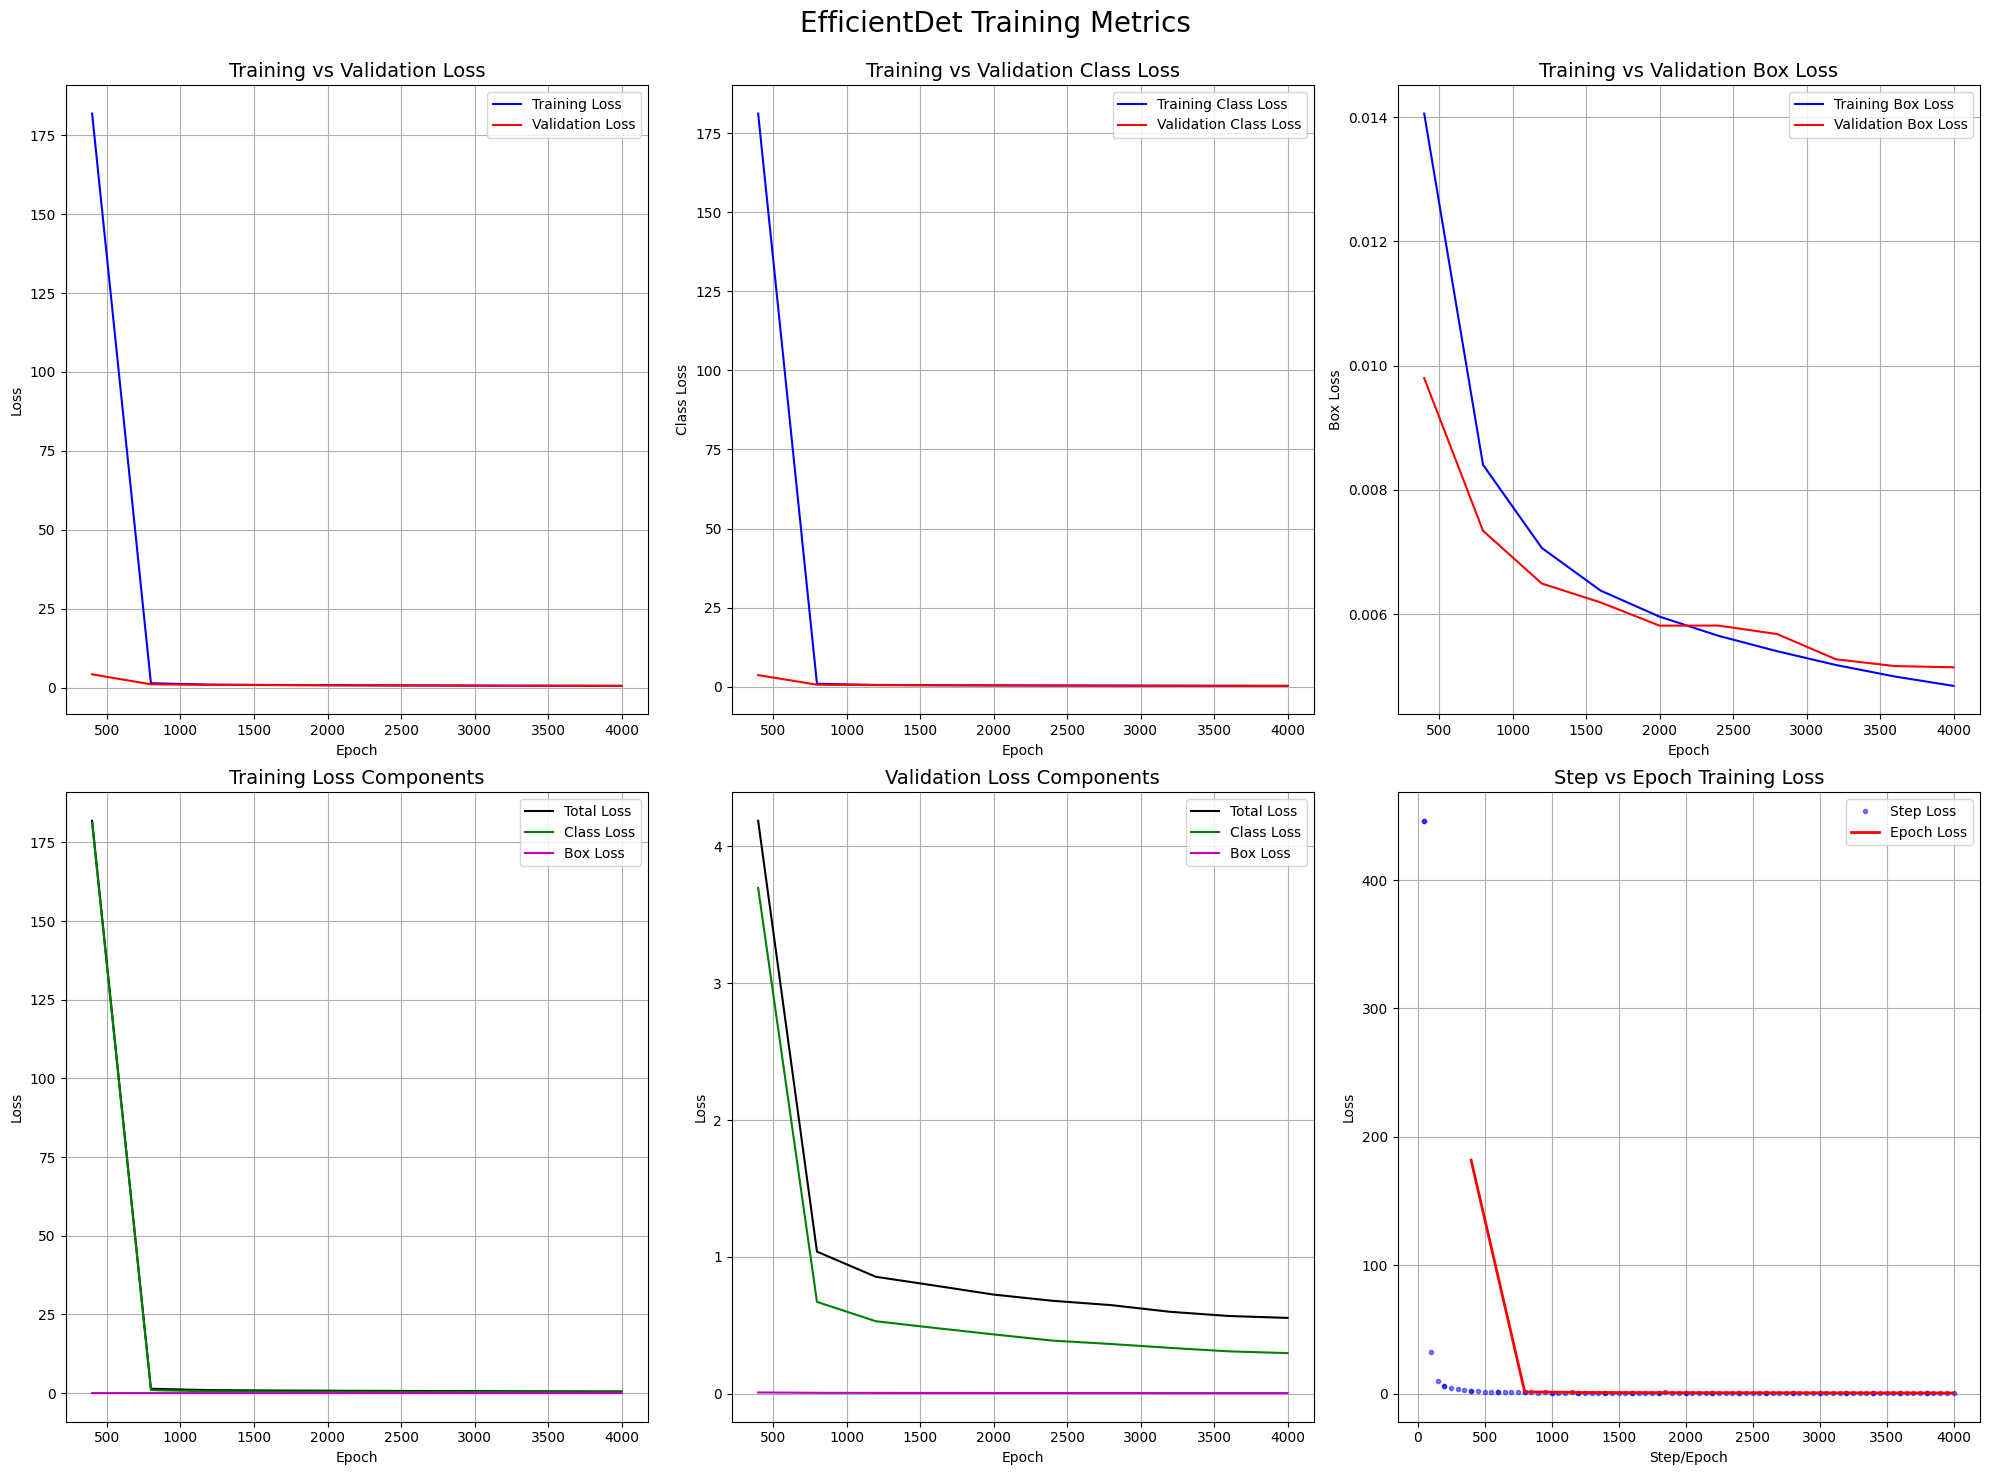

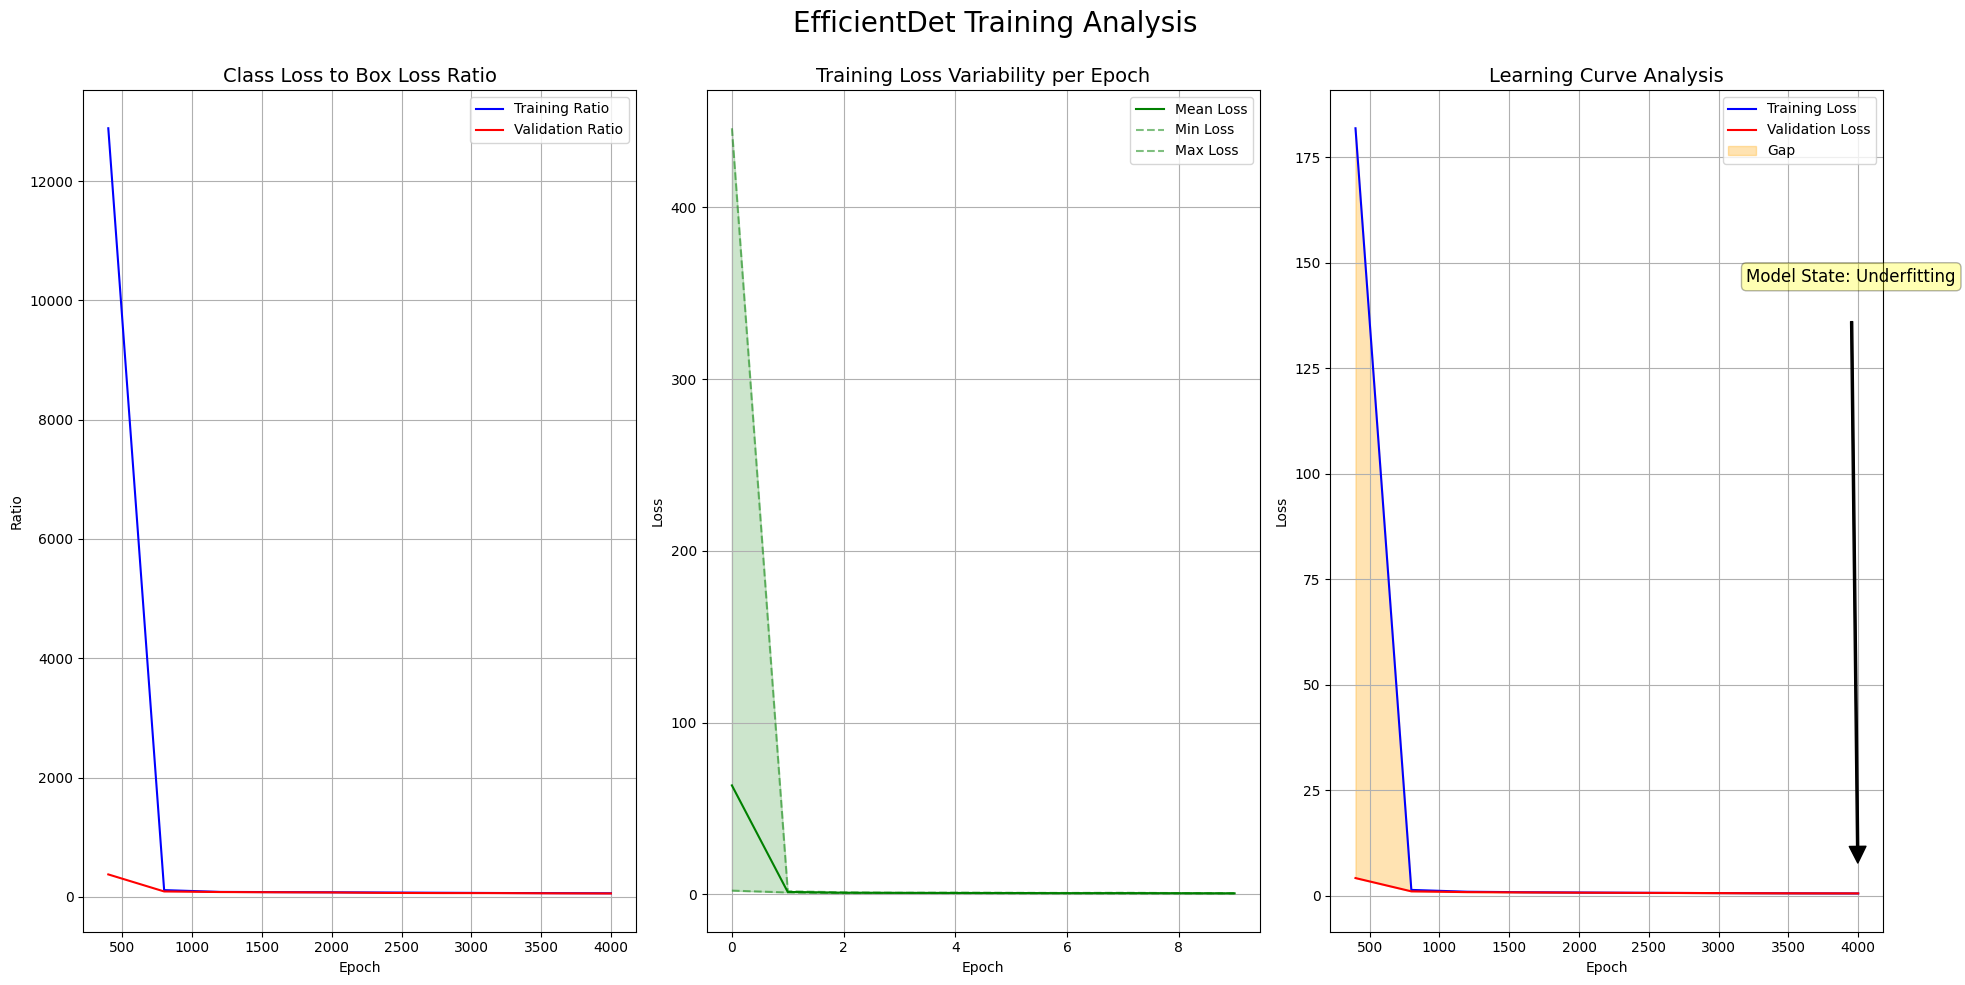

In [18]:
from tensorboard.backend.event_processing import event_accumulator
import glob
event_files = glob.glob('/kaggle/working/lightning_logs/version_0/events.out.tfevents.*')

if event_files:
    ea = event_accumulator.EventAccumulator(event_files[0])
    ea.Reload()
    
    # Create a figure with subplots in a 2x3 grid
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Training vs Validation Loss
    ax1 = fig.add_subplot(2, 3, 1)
    train_loss = ea.Scalars('train_loss_epoch')
    valid_loss = ea.Scalars('valid_loss_epoch')
    train_steps = [x.step for x in train_loss]
    train_values = [x.value for x in train_loss]
    valid_steps = [x.step for x in valid_loss]
    valid_values = [x.value for x in valid_loss]
    
    ax1.plot(train_steps, train_values, 'b-', label='Training Loss')
    ax1.plot(valid_steps, valid_values, 'r-', label='Validation Loss')
    ax1.set_title('Training vs Validation Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # 2. Class Loss (Training vs Validation)
    ax2 = fig.add_subplot(2, 3, 2)
    train_class_loss = ea.Scalars('train_class_loss_epoch')
    valid_class_loss = ea.Scalars('valid_class_loss_epoch')
    train_class_steps = [x.step for x in train_class_loss]
    train_class_values = [x.value for x in train_class_loss]
    valid_class_steps = [x.step for x in valid_class_loss]
    valid_class_values = [x.value for x in valid_class_loss]
    
    ax2.plot(train_class_steps, train_class_values, 'b-', label='Training Class Loss')
    ax2.plot(valid_class_steps, valid_class_values, 'r-', label='Validation Class Loss')
    ax2.set_title('Training vs Validation Class Loss', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Class Loss')
    ax2.legend()
    ax2.grid(True)
    
    # 3. Box Loss (Training vs Validation)
    ax3 = fig.add_subplot(2, 3, 3)
    train_box_loss = ea.Scalars('train_box_loss_epoch')
    valid_box_loss = ea.Scalars('valid_box_loss_epoch')
    train_box_steps = [x.step for x in train_box_loss]
    train_box_values = [x.value for x in train_box_loss]
    valid_box_steps = [x.step for x in valid_box_loss]
    valid_box_values = [x.value for x in valid_box_loss]
    
    ax3.plot(train_box_steps, train_box_values, 'b-', label='Training Box Loss')
    ax3.plot(valid_box_steps, valid_box_values, 'r-', label='Validation Box Loss')
    ax3.set_title('Training vs Validation Box Loss', fontsize=14)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Box Loss')
    ax3.legend()
    ax3.grid(True)
    
    # 4. Loss Components (Training)
    ax4 = fig.add_subplot(2, 3, 4)
    ax4.plot(train_steps, train_values, 'k-', label='Total Loss')
    ax4.plot(train_class_steps, train_class_values, 'g-', label='Class Loss')
    ax4.plot(train_box_steps, train_box_values, 'm-', label='Box Loss')
    ax4.set_title('Training Loss Components', fontsize=14)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.legend()
    ax4.grid(True)
    
    # 5. Loss Components (Validation)
    ax5 = fig.add_subplot(2, 3, 5)
    ax5.plot(valid_steps, valid_values, 'k-', label='Total Loss')
    ax5.plot(valid_class_steps, valid_class_values, 'g-', label='Class Loss')
    ax5.plot(valid_box_steps, valid_box_values, 'm-', label='Box Loss')
    ax5.set_title('Validation Loss Components', fontsize=14)
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Loss')
    ax5.legend()
    ax5.grid(True)
    
    # 6. Step vs Epoch Loss Comparison
    ax6 = fig.add_subplot(2, 3, 6)
    train_loss_step = ea.Scalars('train_loss_step')
    train_loss_step_steps = [x.step for x in train_loss_step]
    train_loss_step_values = [x.value for x in train_loss_step]
    
    # Take a sample of step values to avoid overcrowding
    sample_indices = np.linspace(0, len(train_loss_step_steps)-1, 100, dtype=int)
    sampled_steps = [train_loss_step_steps[i] for i in sample_indices]
    sampled_values = [train_loss_step_values[i] for i in sample_indices]
    
    ax6.plot(sampled_steps, sampled_values, 'b.', alpha=0.5, label='Step Loss')
    ax6.plot(train_steps, train_values, 'r-', linewidth=2, label='Epoch Loss')
    ax6.set_title('Step vs Epoch Training Loss', fontsize=14)
    ax6.set_xlabel('Step/Epoch')
    ax6.set_ylabel('Loss')
    ax6.legend()
    ax6.grid(True)
    
    plt.tight_layout()
    plt.suptitle('EfficientDet Training Metrics', fontsize=20)
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # Create second figure for additional visualizations
    fig2 = plt.figure(figsize=(20, 10))
    
    # 7. Loss ratio: Class Loss vs Box Loss
    ax7 = fig2.add_subplot(1, 3, 1)
    class_box_ratio_train = [c/b if b != 0 else 0 for c, b in zip(train_class_values, train_box_values)]
    class_box_ratio_valid = [c/b if b != 0 else 0 for c, b in zip(valid_class_values, valid_box_values)]
    
    ax7.plot(train_steps, class_box_ratio_train, 'b-', label='Training Ratio')
    ax7.plot(valid_steps, class_box_ratio_valid, 'r-', label='Validation Ratio')
    ax7.set_title('Class Loss to Box Loss Ratio', fontsize=14)
    ax7.set_xlabel('Epoch')
    ax7.set_ylabel('Ratio')
    ax7.legend()
    ax7.grid(True)
    
    # 8. Training loss variability (min, max, mean per epoch)
    ax8 = fig2.add_subplot(1, 3, 2)
    
    # Group step losses by epoch
    max_epoch = max(train_steps)
    epoch_losses = [[] for _ in range(max_epoch + 1)]
    
    valid_loss_step = ea.Scalars('valid_loss_step')
    valid_loss_step_steps = [x.step for x in valid_loss_step]
    valid_loss_step_values = [x.value for x in valid_loss_step]
    
    # Get epoch info
    epoch_scalars = ea.Scalars('epoch')
    epoch_steps = [x.step for x in epoch_scalars]
    epoch_values = [x.value for x in epoch_scalars]
    
    # Map steps to epochs
    step_to_epoch = {}
    for step, epoch in zip(epoch_steps, epoch_values):
        step_to_epoch[step] = int(epoch)
    
    # Group train step losses by epoch
    for step, loss in zip(train_loss_step_steps, train_loss_step_values):
        # Find the closest epoch step
        closest_epoch_step = min(epoch_steps, key=lambda x: abs(x - step))
        epoch = step_to_epoch.get(closest_epoch_step, 0)
        if epoch < len(epoch_losses):
            epoch_losses[epoch].append(loss)
    
    # Calculate statistics
    epoch_nums = list(range(len(epoch_losses)))
    mean_losses = [np.mean(losses) if losses else 0 for losses in epoch_losses]
    min_losses = [np.min(losses) if losses else 0 for losses in epoch_losses]
    max_losses = [np.max(losses) if losses else 0 for losses in epoch_losses]
    
    # Remove empty epochs
    valid_epochs = [i for i, losses in enumerate(epoch_losses) if losses]
    valid_means = [mean_losses[i] for i in valid_epochs]
    valid_mins = [min_losses[i] for i in valid_epochs]
    valid_maxs = [max_losses[i] for i in valid_epochs]
    
    ax8.plot(valid_epochs, valid_means, 'g-', label='Mean Loss')
    ax8.fill_between(valid_epochs, valid_mins, valid_maxs, alpha=0.2, color='g')
    ax8.plot(valid_epochs, valid_mins, 'g--', alpha=0.5, label='Min Loss')
    ax8.plot(valid_epochs, valid_maxs, 'g--', alpha=0.5, label='Max Loss')
    ax8.set_title('Training Loss Variability per Epoch', fontsize=14)
    ax8.set_xlabel('Epoch')
    ax8.set_ylabel('Loss')
    ax8.legend()
    ax8.grid(True)
    
    # 9. Learning Curve Analysis
    ax9 = fig2.add_subplot(1, 3, 3)
    
    # Calculate the difference between training and validation
    train_valid_gap = [t - v for t, v in zip(train_values, valid_values)]
    
    ax9.plot(train_steps, train_values, 'b-', label='Training Loss')
    ax9.plot(valid_steps, valid_values, 'r-', label='Validation Loss')
    ax9.fill_between(train_steps, train_values, valid_values, color='orange', alpha=0.3, label='Gap')
    
    # Add annotations for overfitting/underfitting analysis
    mean_gap = np.mean(train_valid_gap)
    final_gap = train_valid_gap[-1]
    
    if final_gap < 0:
        state = "Underfitting"
    elif final_gap > 0.2:  # Arbitrary threshold
        state = "Overfitting"
    else:
        state = "Good Fit"
    
    ax9.annotate(f'Model State: {state}', 
                xy=(train_steps[-1], (train_values[-1] + valid_values[-1])/2),
                xytext=(train_steps[-1]*0.8, max(train_values + valid_values)*0.8),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))
    
    ax9.set_title('Learning Curve Analysis', fontsize=14)
    ax9.set_xlabel('Epoch')
    ax9.set_ylabel('Loss')
    ax9.legend()
    ax9.grid(True)
    
    plt.tight_layout()
    plt.suptitle('EfficientDet Training Analysis', fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()
else:
    print("No event files found")

In [ ]:
# # Save the model
# torch.save(model.state_dict(), '/kaggle/working/tf_efficientnetv2_b0.pth')

# 4. Model Testing

The section uses the trained models and places the predicting bounding boxes and classifications into a dataframe. Further analysis of performance metrics is done in another notebook.

## 4.1 Load in Trained Model

In [23]:
# Load in model
model = EfficientDetModel(
    num_classes=5,
    img_size=IMG_SIZE,
    model_architecture=MODEL_ARCHITECTURE
)
model.load_state_dict(torch.load('/kaggle/input/tf_efficientnetv2_b0.pth/pytorch/default/1/tf_efficientnetv2_b0.pth'))

{'name': 'tf_efficientnetv2_b0', 'backbone_name': 'tf_efficientnetv2_b0', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 5, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': '

<ipython-input-23-af8c198b2d37>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/tf_efficientnetv2_b0.pth/pytorch/default/1/t

<All keys matched successfully>

## 4.2 Loading and Preprocessing Test Data

In [24]:
test_df = create_df(TEST_ANNO_DIR)
test_dataset = XrayDatasetAdaptor(TEST_IMAGE_DIR, test_df)

# Places indices of different occlusion levels into sets
with open(occlu_lvl_1, 'r') as f:
    occlu_lvl_1_set = set(line.strip() for line in f)
with open(occlu_lvl_2, 'r') as f:
    occlu_lvl_2_set = set(line.strip() for line in f)
with open(occlu_lvl_3, 'r') as f:
    occlu_lvl_3_set = set(line.strip() for line in f)

In [25]:
print(f'Number of Level 1 Occlusion: {len(occlu_lvl_1_set)}')
print(f'Number of Level 2 Occlusion: {len(occlu_lvl_2_set)}')
print(f'Number of Level 3 Occlusion: {len(occlu_lvl_3_set)}')

Number of Level 1 Occlusion: 922
Number of Level 2 Occlusion: 548
Number of Level 3 Occlusion: 306


## 4.3 Store Model Predictions into Dataframe

In [ ]:
# Prepare a list to collect results
results = []

ind_to_filename = test_df.image.unique().tolist()
# Iterate over the test dataset
for ind in range(len(test_dataset)):
    # Load data
    image1, truth_bboxes1, class_labels, index = test_dataset.get_image_and_labels_by_idx(ind)

    # Predict
    predicted_bboxes, predicted_class_labels, predicted_class_confidences = model.predict_list([image1])

    img_filename = ind_to_filename[ind]

    # Remove '.jpg' if needed (depends how filenames are stored in text files)
    img_name_no_ext = img_filename.replace('.jpg', '')

    # Determine occlusion level
    if img_name_no_ext in occlu_lvl_1_set:
        occlusion_level = 1
    elif img_name_no_ext in occlu_lvl_2_set:
        occlusion_level = 2
    elif img_name_no_ext in occlu_lvl_3_set:
        occlusion_level = 3
    else:
        occlusion_level = 0

    # Assuming one object per image (if multiple, you would need a nested loop)
    result = {
        'image_filename': img_filename,
        'ground_truth_bbox': truth_bboxes1,
        'predicted_bbox': predicted_bboxes,
        'ground_truth_class': class_labels,
        'predicted_class': predicted_class_labels,
        'occlusion_level': occlusion_level
    }
    results.append(result)

# Create a DataFrame
results_df = pd.DataFrame(results)

# View or save the DataFrame
print(results_df.head())

In [ ]:
# # Save results
# results_df.to_csv('/kaggle/working/efficientdet_results.csv', index=False)

## 4.4 Display example of Model Prediction

In [26]:
def compare_bboxes_for_image(
    image,
    predicted_bboxes,
    actual_bboxes,
    draw_bboxes_fn=draw_pascal_voc_bboxes,
    figsize=(20, 20),
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(image)
    ax1.set_title("Prediction")
    ax2.imshow(image)
    ax2.set_title("Actual")

    draw_bboxes_fn(ax1, predicted_bboxes)
    draw_bboxes_fn(ax2, actual_bboxes)

    plt.show()

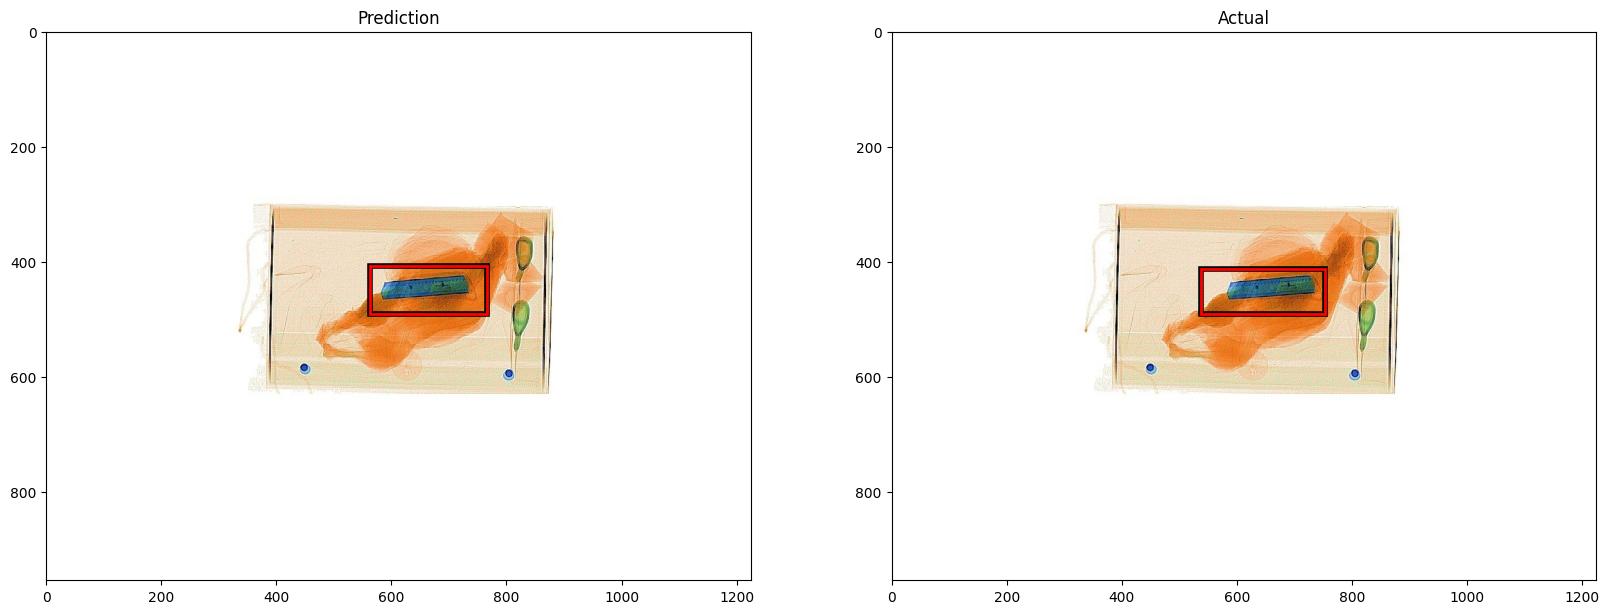

In [27]:
random_ind = random.randint(0, len(test_dataset)-1)
image1, truth_bboxes1, class_labels, index = test_dataset.get_image_and_labels_by_idx(random_ind)

model.eval()
predicted_bboxes,  predicted_class_labels, predicted_class_confidences = model.predict_list([image1])
compare_bboxes_for_image(image1, predicted_bboxes=predicted_bboxes[0], actual_bboxes=truth_bboxes1.tolist())


# 5. GradCam Analysis

## 5.1 Grad-CAM Function
This function generates visual explanations for EfficientDet object detection models by implementing Gradient-weighted Class Activation Mapping (Grad-CAM). It:
- Locates a target layer in the model architecture
- Processes an input image through the model while capturing activations
- Backpropagates gradients from a detection score
- Computes a heatmap showing which image regions most influenced the detection
- Creates visualizations of the original image, heatmap, and an overlay with bounding boxes

In [33]:
def lightning_gradcam(lightning_model, img_path, target_layer_name=None, class_idx=0, visualize=True, threshold=0.2, printScores=False):
    """
    Grad-CAM implementation for EfficientDetModel Lightning Module
    
    Args:
        lightning_model: Your EfficientDetModel Lightning module
        img_path: Path to the input image
        target_layer_name: Name of the target layer (if None, will use a default)
        class_idx: Index of the class to analyze (default: 0 (folding-knife))
        visualize: Whether to display the visualization
        threshold: Detection confidence threshold (can override model's default)
        
    Returns:
        original_image: The original input image
        heatmap: The Grad-CAM heatmap
        cam_image: The original image with heatmap overlay
    """
    # Access the actual model from the Lightning module
    model = lightning_model.model
    
    # Set default target layer if not provided
    if target_layer_name is None:
        # Default to the last convolutional layer of the backbone
        # This assumes a 'backbone' attribute exists in the model structure
        if hasattr(model, 'backbone'):
            target_layer = model.backbone
            for name, module in model.backbone.named_modules():
                if isinstance(module, torch.nn.Conv2d):
                    target_layer = module
            target_layer_name = 'backbone.conv_head'
        else:
            # Try common layer structures in EfficientDet
            target_layer_name = 'backbone.conv_head'
    
    # Set up storage for activations and gradients
    activations = []
    gradients = []
    
    def save_activation(module, input, output):
        activations.append(output.detach())
    
    # Find target layer and register hooks
    target_layer = None
    
    # Recursive function to find and return the target layer
    def find_layer(module, name):
        for n, child in module.named_children():
            if n == name:
                return child
            try:
                found = find_layer(child, name)
                if found is not None:
                    return found
            except:
                pass
        return None
    
    # If the target_layer_name contains dots, we need to navigate the hierarchy
    parts = target_layer_name.split('.')
    current_module = model
    
    for part in parts:
        if hasattr(current_module, part):
            current_module = getattr(current_module, part)
        else:
            # If the part is not found directly, try to find it recursively
            found = find_layer(current_module, part)
            if found is not None:
                current_module = found
            else:
                print(f"Could not find layer part: {part} in {target_layer_name}")
                break
    
    target_layer = current_module
    
    if target_layer is None:
        print(f"Could not find target layer: {target_layer_name}")
        # Fallback: print available layer names to help debugging
        print("Available layers:")
        for name, _ in model.named_modules():
            print(f"  {name}")
        return None, None, None
    
    # Register forward hook
    handle_forward = target_layer.register_forward_hook(save_activation)
    
    # Create a gradient extraction mechanism without using backward hooks
    # This avoids hook compatibility issues
    def extract_gradients():
        if hasattr(target_layer, 'weight') and target_layer.weight is not None and target_layer.weight.grad is not None:
            # If we can access the gradients directly
            return target_layer.weight.grad
        else:
            # Otherwise, try to extract them from output activations
            if len(activations) > 0 and activations[0].grad is not None:
                return activations[0].grad
            return None
    
    # Load and preprocess image
    img = Image.open(img_path).convert('RGB')
    original_img = np.array(img)
    
    # Get the image size from the model
    img_size = lightning_model.img_size
    
    # Use the model's inference transforms if available
    if hasattr(lightning_model, 'inference_tfms') and lightning_model.inference_tfms is not None:
        transformed = lightning_model.inference_tfms(
            image=np.array(original_img, dtype=np.float32),
            labels=np.ones(1),
            bboxes=np.array([[0, 0, 1, 1]]),
        )
        img_tensor = transformed["image"].unsqueeze(0)
    else:
        # Manual preprocessing
        img_resized = img.resize((img_size, img_size))
        img_tensor = torch.tensor(np.array(img_resized), dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
        img_tensor = img_tensor / 255.0
        
        # Normalize with ImageNet mean and std
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        img_tensor = (img_tensor - mean) / std
    
    # Create dummy targets for inference
    dummy_targets = lightning_model._create_dummy_inference_targets(num_images=1)
    
    # Set model to evaluation mode
    original_training = model.training
    model.eval()
    
    # Get the device
    device = next(model.parameters()).device
    img_tensor = img_tensor.to(device)
    
    # Set custom threshold if specified
    original_threshold = None
    if threshold is not None and hasattr(lightning_model, 'prediction_confidence_threshold'):
        original_threshold = lightning_model.prediction_confidence_threshold
        lightning_model.prediction_confidence_threshold = threshold
    
    # Forward pass with gradient calculation
    img_tensor.requires_grad = True
    
    with torch.enable_grad():
        outputs = model(img_tensor, dummy_targets)
        
        # Extract detections
        detections = outputs["detections"]
        
        # Process detections to find the target class
        boxes = detections[0].detach().cpu().numpy()[:, :4]
        scores = detections[0].detach().cpu().numpy()[:, 4]
        classes = detections[0].detach().cpu().numpy()[:, 5]
        
        # Print all detected classes and scores for debugging
        if printScores:
            print(f"Detected classes: {classes}")
            print(f"Scores: {scores}")
        
        # Find detections of the target class above threshold
        current_threshold = lightning_model.prediction_confidence_threshold
        target_indices = np.where((classes == class_idx) & (scores > current_threshold))[0]
        
        if len(target_indices) == 0:
            print(f"No detections found for class {class_idx} above threshold {current_threshold}.")
            # Try with any class if no specific class found
            best_idx = np.argmax(scores)
            if scores[best_idx] > current_threshold:
                print(f"Using highest scoring detection (class {classes[best_idx]}, score {scores[best_idx]}).")
                target_class = int(classes[best_idx])
            else:
                print("No detections above threshold for any class.")
                handle_forward.remove()
                # Restore original threshold if modified
                if original_threshold is not None:
                    lightning_model.prediction_confidence_threshold = original_threshold
                # Restore original training state
                model.train(original_training)
                return original_img, None, None
        else:
            # Get the highest scoring detection of target class
            best_idx = target_indices[np.argmax(scores[target_indices])]
            target_class = class_idx
        
        # Get the relevant score for backpropagation
        # Find the corresponding tensor in the model output that represents this score
        relevant_score = detections[0, best_idx, 4]
        print(f"Using detection with score: {relevant_score.item()}")
        
        # Backward pass
        model.zero_grad()
        relevant_score.backward()
    
    # Get the activations
    if not activations:
        print("No activations captured. Check target layer.")
        handle_forward.remove()
        # Restore original threshold if modified
        if original_threshold is not None:
            lightning_model.prediction_confidence_threshold = original_threshold
        # Restore original training state
        model.train(original_training)
        return original_img, None, None
    
    act = activations[0]
    
    # Get gradients with respect to the activations
    if act.grad is not None:
        grad = act.grad
    else:
        print("No gradients captured. Using gradients from activation's output.")
        # Try alternative approach to get gradients
        # This is a workaround when backward hooks don't work
        if hasattr(target_layer, 'weight') and target_layer.weight.grad is not None:
            # Calculate approximate gradients
            grad = torch.ones_like(act) * target_layer.weight.grad.sum()
        else:
            print("Could not capture gradients through any method.")
            handle_forward.remove()
            # Restore original threshold if modified
            if original_threshold is not None:
                lightning_model.prediction_confidence_threshold = original_threshold
            # Restore original training state
            model.train(original_training)
            return original_img, None, None
    
    # Remove hooks
    handle_forward.remove()
    
    # Restore original threshold if modified
    if original_threshold is not None:
        lightning_model.prediction_confidence_threshold = original_threshold
    
    # Restore original training state
    model.train(original_training)
    
    # Calculate weights (global average pooling of gradients)
    weights = torch.mean(grad, dim=(2, 3)).unsqueeze(-1).unsqueeze(-1)
    
    # Apply weights to activation maps
    cam = torch.sum(weights * act, dim=1).squeeze(0)
    
    # Apply ReLU
    cam = F.relu(cam)
    
    # Normalize
    if torch.max(cam) > 0:
        cam = cam / torch.max(cam)
    
    # Convert to numpy and resize to original image size
    cam = cam.detach().cpu().numpy()
    cam = cv2.resize(cam, (original_img.shape[1], original_img.shape[0]))
    
    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Superimpose heatmap on original image
    alpha = 0.4
    cam_image = heatmap * alpha + original_img * (1 - alpha)
    cam_image = np.uint8(cam_image)
    
    # Visualize results
    if visualize:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(original_img)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(heatmap)
        plt.title('Grad-CAM Heatmap')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(cam_image)
        plt.title('Grad-CAM Overlay')
        plt.axis('off')
        
        # Add bounding box of detected object
        bbox = boxes[best_idx]
        # Scale bbox if needed
        if img_size != original_img.shape[0] or img_size != original_img.shape[1]:
            h, w = original_img.shape[:2]
            bbox = bbox * np.array([w/img_size, h/img_size, w/img_size, h/img_size])
        
        # Draw on original image
        rect = plt.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            fill=False,
            edgecolor='green',
            linewidth=2
        )
        plt.subplot(1, 3, 1).add_patch(rect)
        
        # Draw on overlay
        rect = plt.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            fill=False,
            edgecolor='green',
            linewidth=2
        )
        plt.subplot(1, 3, 3).add_patch(rect)
        
        # Add text with class and score
        plt.subplot(1, 3, 1).text(
            bbox[0], bbox[1] - 5,
            f"Class: {target_class}, Score: {scores[best_idx]:.2f}",
            color='white', fontsize=10, backgroundcolor='green'
        )
        
        plt.tight_layout()
        plt.show()
    
    return original_img, heatmap, cam_image

Using detection with score: 0.49495649337768555
No gradients captured. Using gradients from activation's output.


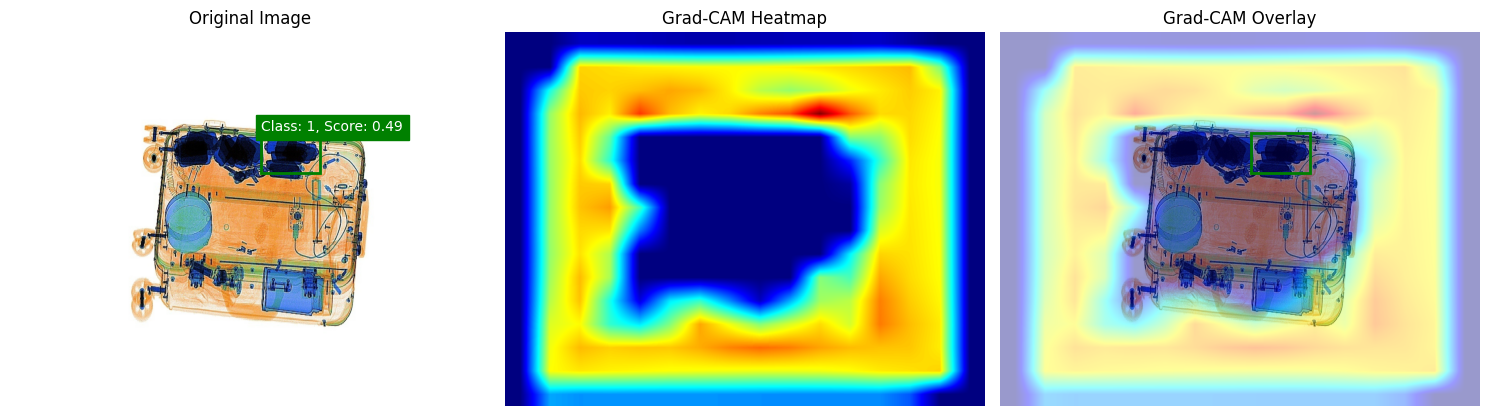

In [55]:
# Find suitable target layers
# target_layer = "model.class_net.predict.conv_pw"
target_layer = 'model.backbone.blocks.5.7.conv_pwl'

# Generate Grad-CAM with a lower threshold
orig_img, heatmap, cam_img = lightning_gradcam(
    model,
    '/kaggle/input/opi-xray-dataset/OPIXray_dataset/test/test_image/010627.jpg',
    target_layer_name=target_layer,
    class_idx=1,  # Class index (e.g., 0 for knife in OPIXray)
    visualize=True,
    threshold=0.4,  # Try a much lower threshold
    printScores = False
)

Using detection with score: 0.5660432577133179
No gradients captured. Using gradients from activation's output.


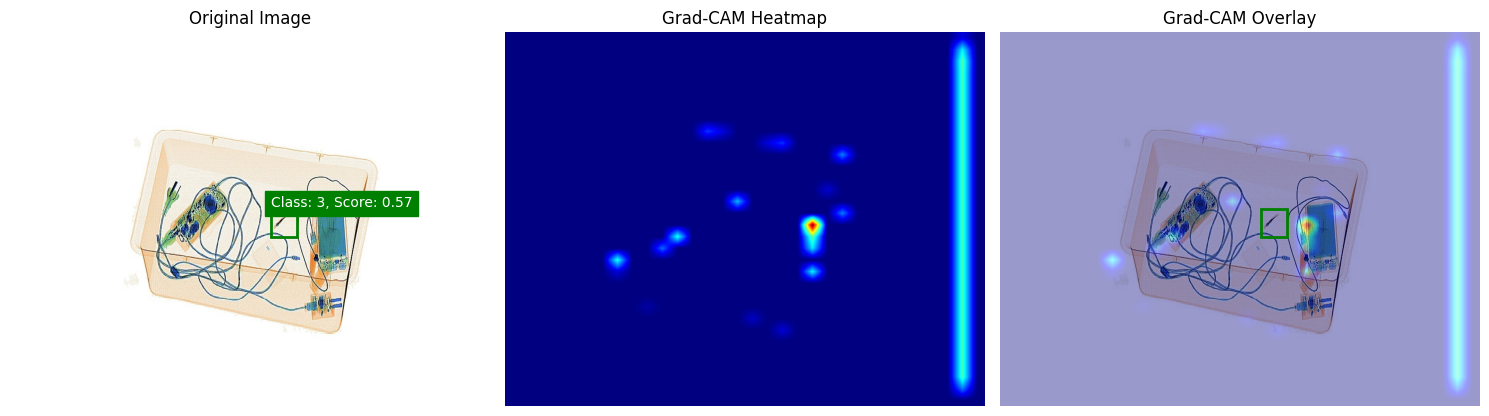

In [69]:
# target_layer = 'model.class_net.predict.conv_pw'
target_layer = 'model.backbone.blocks.3.2.conv_pwl'
orig_img, heatmap, cam_img = lightning_gradcam(
    model,
    '/kaggle/input/opi-xray-dataset/OPIXray_dataset/test/test_image/010797.jpg',
    target_layer_name=target_layer,
    class_idx=3,  # Class index (e.g., 0 for knife in OPIXray)
    visualize=True,
    threshold=0.4,  # Try a much lower threshold
    printScores = False
)

In [ ]:
Backbone Entry Points:

model.backbone.stem.conv


Additional Backbone Blocks:

model.backbone.blocks.1.1.conv_pwl
model.backbone.blocks.2.0.conv_pwl (Mid-level features)
model.backbone.blocks.3.2.conv_pwl',
model.backbone.blocks.4.3.conv_pwl (Deeper features)
model.backbone.blocks.5.7.conv_pwl',
model.backbone.blocks.6.0.conv_pwl (Deepest features)

BiFPN Output Nodes:

model.fpn.cell.0.fnode.0.after_combine.conv.conv_pw
model.fpn.cell.1.fnode.3.after_combine.conv.conv_pw
model.fpn.cell.2.fnode.0.after_combine.conv.conv_pw (P3 level)
model.fpn.cell.2.fnode.1.after_combine.conv.conv_pw (P4 level)
model.fpn.cell.2.fnode.2.after_combine.conv.conv_pw (P5 level)
model.fpn.cell.2.fnode.7.after_combine.conv.conv_pw
        
    

    target_layers = [
        # Backbone layers - from earlier to deeper
        'model.backbone.blocks.1.1.conv_pwl',
        'model.backbone.blocks.3.2.conv_pwl',
        'model.backbone.blocks.5.7.conv_pwl',
        
        # Class or box network layers (optional)
        'model.class_net.predict.conv_pw',
        'model.box_net.predict.conv_pw'
    ]

model.class_net.predict.conv_pw: Classification head
model.box_net.predict.conv_pw: Bounding box regression head

Processing layer: model.backbone.blocks.1.1.conv_pwl
No detections found for class 2 above threshold 0.4.
Using highest scoring detection (class 1.0, score 0.7163982391357422).
Using detection with score: 0.7163982391357422
No gradients captured. Using gradients from activation's output.
Processing layer: model.backbone.blocks.3.2.conv_pwl
No detections found for class 2 above threshold 0.4.
Using highest scoring detection (class 1.0, score 0.7163982391357422).
Using detection with score: 0.7163982391357422
No gradients captured. Using gradients from activation's output.
Processing layer: model.backbone.blocks.5.7.conv_pwl
No detections found for class 2 above threshold 0.4.
Using highest scoring detection (class 1.0, score 0.7163982391357422).
Using detection with score: 0.7163982391357422
No gradients captured. Using gradients from activation's output.
Processing layer: model.fpn.cell.0.fnode.0.after_combine.conv.conv_pw
No detections found for class 2 above threshold 0.4.
Using high

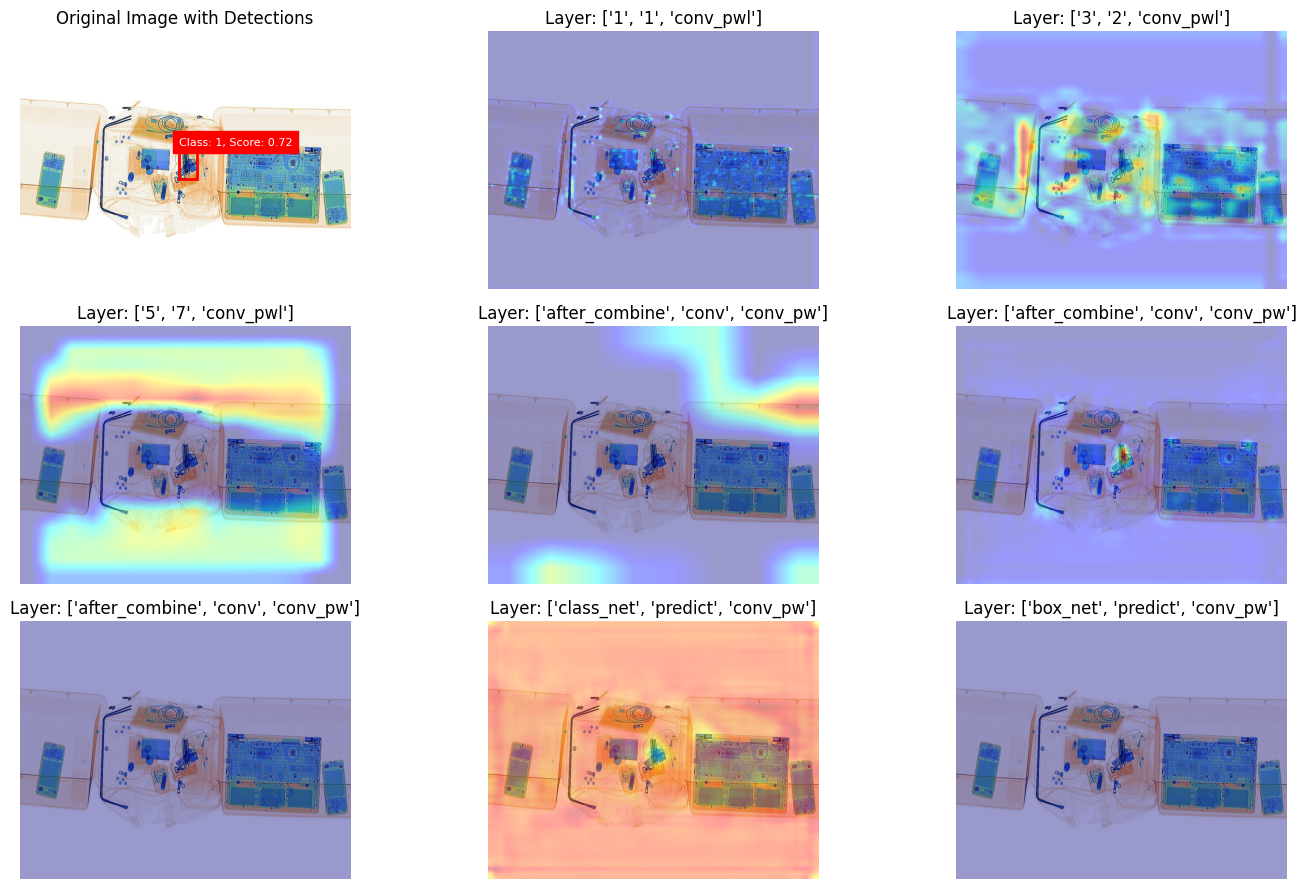

In [79]:
model.eval()
visualize_multiple_layers(
    model,
    '/kaggle/input/opi-xray-dataset/OPIXray_dataset/test/test_image/039983.jpg',
    class_idx=2,  # The class detected in your image
    threshold=0.4
)

In [75]:
def visualize_multiple_layers(model, img_path, class_idx=0, threshold=0.1):
    """
    Visualize Grad-CAM results across multiple layers of the model
    
    Args:
        model: Your EfficientDet model
        img_path: Path to the input image
        class_idx: Index of the class to visualize
        threshold: Detection confidence threshold
    """
    # Define layers to visualize
    target_layers = [
        # Backbone layers - from earlier to deeper
        'model.backbone.blocks.1.1.conv_pwl',
        'model.backbone.blocks.3.2.conv_pwl',
        'model.backbone.blocks.5.7.conv_pwl',
        
        # FPN layers
        'model.fpn.cell.0.fnode.0.after_combine.conv.conv_pw',
        'model.fpn.cell.1.fnode.3.after_combine.conv.conv_pw',
        'model.fpn.cell.2.fnode.7.after_combine.conv.conv_pw',
        
        # Class or box network layers (optional)
        'model.class_net.predict.conv_pw',
        'model.box_net.predict.conv_pw'
    ]
    
    # Create a figure with subplots
    num_layers = len(target_layers)
    fig_height = max(5, 3 * ((num_layers + 2) // 3))  # Adjust height based on number of layers
    plt.figure(figsize=(15, fig_height))
    
    # First, get detections to draw bounding boxes
    # We need to run inference to get all detections
    img_tensor = preprocess_image_for_model(model, img_path)
    dummy_targets = model._create_dummy_inference_targets(num_images=1)
    
    # Forward pass
    outputs = model.model(img_tensor.to(next(model.parameters()).device), dummy_targets)
    detections = outputs["detections"]
    
    # Process detections
    boxes = detections[0].detach().cpu().numpy()[:, :4]
    scores = detections[0].detach().cpu().numpy()[:, 4]
    classes = detections[0].detach().cpu().numpy()[:, 5]
    
    # Filter by threshold
    valid_indices = np.where(scores > threshold)[0]
    filtered_boxes = boxes[valid_indices]
    filtered_scores = scores[valid_indices]
    filtered_classes = classes[valid_indices]
    
    # First subplot - original image
    plt.subplot(((num_layers + 2) // 3), 3, 1)
    orig_img = np.array(Image.open(img_path).convert('RGB'))
    plt.imshow(orig_img)
    plt.title('Original Image with Detections')
    plt.axis('off')
    
    # Resize bboxes to original image size if needed
    img_size = model.img_size
    h, w = orig_img.shape[:2]
    if img_size != h or img_size != w:
        scale_factors = np.array([w/img_size, h/img_size, w/img_size, h/img_size])
        filtered_boxes = filtered_boxes * scale_factors
    
    # Draw bounding boxes on original image
    for i, (box, score, cls) in enumerate(zip(filtered_boxes, filtered_scores, filtered_classes)):
        color = 'green' if cls == class_idx else 'red'
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            fill=False,
            edgecolor=color,
            linewidth=2
        )
        plt.gca().add_patch(rect)
        plt.text(
            box[0], box[1] - 5,
            f"Class: {int(cls)}, Score: {score:.2f}",
            color='white', fontsize=8, backgroundcolor=color
        )
    
    # Generate Grad-CAM for each layer
    for i, layer in enumerate(target_layers):
        print(f"Processing layer: {layer}")
        try:
            _, heatmap, cam_img = lightning_gradcam(
                model,
                img_path,
                target_layer_name=layer,
                class_idx=class_idx,
                threshold=threshold,
                visualize=False  # Don't visualize individually
            )
            
            # Plot the result
            plt.subplot(((num_layers + 2) // 3), 3, i + 2)
            if cam_img is not None:
                plt.imshow(cam_img)
                plt.title(f"Layer: {layer.split('.')[-3:]}")
                
                # Optionally, draw bounding boxes on the CAM images too
                for j, (box, score, cls) in enumerate(zip(filtered_boxes, filtered_scores, filtered_classes)):
                    if cls == class_idx:  # Only draw boxes for the target class on CAM images
                        rect = plt.Rectangle(
                            (box[0], box[1]),
                            box[2] - box[0],
                            box[3] - box[1],
                            fill=False,
                            edgecolor='green',
                            linewidth=1
                        )
                        plt.gca().add_patch(rect)
            else:
                plt.imshow(orig_img)
                plt.title(f"No CAM: {layer.split('.')[-3:]}")
            plt.axis('off')
        except Exception as e:
            print(f"Error with layer {layer}: {e}")
            plt.subplot(((num_layers + 2) // 3), 3, i + 2)
            plt.text(0.5, 0.5, f"Error with layer", 
                     ha='center', va='center', transform=plt.gca().transAxes)
            plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('gradcam_multiple_layers.png', dpi=300, bbox_inches='tight')
    plt.show()

def preprocess_image_for_model(model, img_path):
    """Helper function to preprocess an image for the model"""
    img = Image.open(img_path).convert('RGB')
    img_size = model.img_size
    
    # Use the model's inference transforms if available
    if hasattr(model, 'inference_tfms') and model.inference_tfms is not None:
        transformed = model.inference_tfms(
            image=np.array(img, dtype=np.float32),
            labels=np.ones(1),
            bboxes=np.array([[0, 0, 1, 1]]),
        )
        img_tensor = transformed["image"].unsqueeze(0)
    else:
        # Manual preprocessing
        img_resized = img.resize((img_size, img_size))
        img_tensor = torch.tensor(np.array(img_resized), dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
        img_tensor = img_tensor / 255.0
        
        # Normalize with ImageNet mean and std
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        img_tensor = (img_tensor - mean) / std
    
    return img_tensor